**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# Tutorial 4: Predicting Popularity of Online News

In this tutorial you will train regression models to predict the number of "shares" of a news article on Mashable.

First we need to initialize Python.  Run the below cell.

In [ ]:
%matplotlib inline
import IPython.core.display
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
random.seed(100)

## 1. Loading Data and Pre-processing
Next we need to load the data.  Download `OnlineNewsPopularity.zip`, and **unzip** it in the same directory as this ipynb file.  Then run the following cell to load the data.

In [ ]:
filename = 'OnlineNewsPopularity/OnlineNewsPopularity.csv'

# read the data
allfeatnames = []
textdata      = []
with open(filename, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(allfeatnames)==0:
            allfeatnames = row
        else:
            textdata.append(row)

# put the data into a np array
dataX = empty((len(textdata), len(allfeatnames)-3))
dataY = empty(len(textdata))
for i,row in enumerate(textdata):
    # extract features (remove the first 2 features and the last feature)
    dataX[i,:] = array([float(x) for x in row[2:-1]])
    # extract target (last entry)
    dataY[i] = float(row[-1])

# extract feature names
featnames = [x.strip() for x in allfeatnames[2:-1]]

# extract a subset of data
dataX = dataX[::6]
dataY = dataY[::6]

print(dataX.shape)
print(dataY.shape)

(6608, 58)
(6608,)


There are 58 features for each article.  Here are the feature names, and an example entry.  The actual description of the features can be found in the `OnlineNewsPopularity-features.txt` file.

In [ ]:
print(featnames)

print("--- example article features---")
print(dataX[0])
print("--- example article target (# of shares)")
print(dataY[0])

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarit

Now separate the data into training and testing sets.

In [ ]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainYo, testYo = \
  model_selection.train_test_split(dataX, dataY,
  train_size=0.50, test_size=0.50, random_state=4487)

print(trainX.shape)
print(testX.shape)

(3304, 58)
(3304, 58)


Finally, we normalize the input features.

In [ ]:
# normalize feature values
# this makes comparing weights more meaningful
scaler = preprocessing.StandardScaler()
trainXn = scaler.fit_transform(trainX)
testXn  = scaler.transform(testX)

Because the target value (number of shares) has a large dynamic range, we will transform the target values through the log function.

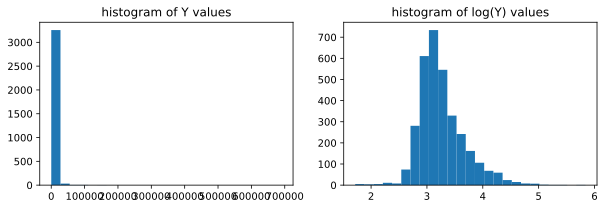

In [ ]:
# map targets to log-space
trainY = log10(trainYo)
testY  = log10(testYo)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(trainYo, 25);
plt.title('histogram of Y values')
plt.subplot(1,2,2)
plt.hist(trainY, 25);
plt.title("histogram of log(Y) values");

## 2. Prediction with Linear Regression

First we will look at predicting the number of shares using simple linear regression models.  Use the training data to fit a linear model using Ordinary Least Squares and Ridge Regression.  Use cross-validation on the training set to select the optimal $\alpha$ parameter for ridge regression.

In [ ]:
### INSERT YOUR CODE HERE
## HINT:
# 1. Ordinary Least Squares: linear_model.LinearRegression()
# 2. Ridge Regression: linear_model.Ridge(alphas= )
# 3. Rigge Regression with Cross-validation: linear_model.Ridge(alphas= )

In [ ]:
### INSERT YOUR CODE HERE
ols = linear_model.LinearRegression()
ols.fit(trainXn, trainY)

trainAE = metrics.mean_absolute_error(trainY, ols.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, ols.predict(testXn))

print("train error:", trainAE)
print("test error :", testAE)

train error: 0.2868856437837091
test error : 187.72428004424154


best alpha:  385.6620421163472
train error:  0.28859917591560874
test error :  0.2854267347255127


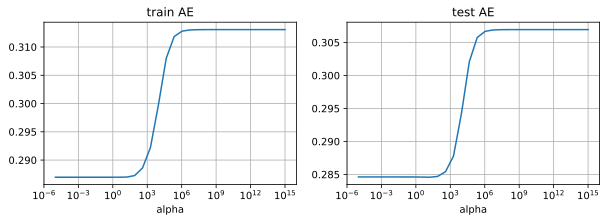

In [ ]:
### INSERT YOUR CODE HERE
alphas = logspace(-5,15,30)

trainAEs = empty(len(alphas))
testAEs  = empty(len(alphas))
for i,a in enumerate(alphas):
    rr = linear_model.Ridge(alpha=a)
    rr.fit(trainXn, trainY)

    trainAEs[i] = metrics.mean_absolute_error(trainY, rr.predict(trainXn))
    testAEs[i]  = metrics.mean_absolute_error(testY, rr.predict(testXn))

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.semilogx(alphas, trainAEs)
plt.xlabel('alpha')
plt.title('train AE')
plt.grid(True)
plt.subplot(1,2,2)
plt.semilogx(alphas, testAEs)
plt.xlabel('alpha')
plt.title('test AE')
plt.grid(True)

rr = linear_model.RidgeCV(alphas=alphas, cv=5)
rr.fit(trainXn, trainY)

print("best alpha: ", rr.alpha_)

trainAE = metrics.mean_absolute_error(trainY, rr.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY,  rr.predict(testXn))

print("train error: ", trainAE)
print("test error : ", testAE)

Compare the two models using the _average absolute error_ (AE) between the predictions and the true values.  Below is  code that will calculate AE for the training and test sets.

In [ ]:
# ols is the linear regression model
trainAE = metrics.mean_absolute_error(trainY, ols.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, ols.predict(testXn))
print("OLS: train error =", trainAE)
print("OLS: test error =", testAE)

OLS: train error = 0.2868856437837091
OLS: test error = 187.72428004424154


In [ ]:
# rr is the ridge regression model
trainAE = metrics.mean_absolute_error(trainY, rr.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, rr.predict(testXn))
print("RR: train error =", trainAE)
print("RR: test error =", testAE)

RR: train error = 0.28859917591560874
RR: test error = 0.2854267347255127


Which model has better prediction ability on the test set? Why?
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- RR has better performance. selecting the best alpha prevents overfitting.  
- OLS has severe overfitting -- very bad performance on test set.

## 3. Which features are important?
Next we will investigate which features are the most important for the prediction.  Use LASSO with cross-validation to learn the model, and print the training and testing error.

In [ ]:
### INSERT YOUR CODE HERE
## HINT
# 1. LASSO with Cross-validation: linear_model.LassoCV()

In [ ]:
### INSERT YOUR CODE HERE
las = linear_model.LassoCV()
las.fit(trainXn, trainY)

trainAE = metrics.mean_absolute_error(trainY, las.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, las.predict(testXn))
print(trainAE)
print(testAE)

0.2884555818253427
0.2847674710353574


Examine the LASSO coefficients by sorting them in descending order.

In [ ]:
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(las.coef_))[::-1]
# print out
print("weight : feature description")
for i in inds:
    print("{: .3f} : {}".format(las.coef_[i], featnames[i]))

weight : feature description
 0.098 : kw_avg_avg
-0.042 : LDA_02
-0.041 : kw_max_avg
-0.034 : data_channel_is_entertainment
-0.027 : average_token_length
 0.026 : global_subjectivity
 0.025 : num_hrefs
-0.023 : data_channel_is_bus
 0.022 : kw_min_min
 0.022 : is_weekend
 0.022 : LDA_00
 0.020 : n_tokens_content
-0.018 : kw_avg_min
 0.018 : data_channel_is_socmed
 0.014 : self_reference_avg_sharess
-0.013 : max_positive_polarity
 0.013 : title_sentiment_polarity
-0.012 : data_channel_is_lifestyle
 0.009 : weekday_is_sunday
-0.008 : kw_avg_max
-0.008 : LDA_01
 0.007 : self_reference_max_shares
 0.007 : n_tokens_title
-0.007 : avg_negative_polarity
 0.007 : num_keywords
-0.006 : kw_min_max
 0.006 : weekday_is_monday
-0.005 : weekday_is_friday
 0.005 : data_channel_is_tech
-0.004 : num_self_hrefs
-0.004 : weekday_is_tuesday
 0.003 : LDA_03
-0.003 : min_positive_polarity
-0.003 : rate_positive_words
-0.002 : max_negative_polarity
 0.002 : self_reference_min_shares
 0.002 : num_imgs
 0.001 :

_Which features are most important for predicting the number of shares?  For these features, which feature values (low or high values) will yield a higher number of shares?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
  - kw_avg_avg -- keywords that have large average number of shares (large)
  - LDA02 -- related to LDA topic 2 (low)
  - kw_max_avg -- number of keywords with max shares? (low)
  - data_channel_is_entertainment -- entertainment channel! (low)
  - avg_token_length -- length of words (low)

## 4. Kernel Methods and Supprot Vector Regression
Next, let us try some non-linear regression model such as[ kernel ridge regression](https://scikit-learn.org/stable/modules/kernel_ridge.html), [random forest regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)(Optional), [support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html). To improve the prediction accuracy in Tutorial 3, and using cross-validation on the training set to select the parameters.

In [ ]:
### INSERT YOUR CODE HERE
##Hint:
## 1. Kernel Ridge Regression:  kernel_ridge.KernelRidge(kernel='rbf'/'poly')
## 2. Random Forest Regression: ensemble.RandomForestRegressor(random_state= , n_estimators= )
## 3. Support Vector Regression: svm.SVR(kernel='poly')
## 4. Avoid using large values of $C$ with SVR.

In [ ]:
allexps = [
    {'name': 'krr-rbf',
     'clf': kernel_ridge.KernelRidge(kernel='rbf'),
     'params': {'alpha': logspace(-3,3,10), 'gamma': logspace(-6,3,10)}
    },
    {'name': 'krr-poly',
     'clf': kernel_ridge.KernelRidge(kernel='poly'),
     'params': {'alpha': logspace(-3,3,10), 'degree': [1,2,3,4,5]}
    },
    {'name': 'rf',
     'clf': ensemble.RandomForestRegressor(random_state=4487, n_estimators=100),
     'params': {'max_depth': array([1, 2, 3, 4, 5, 10, 15])}
    },
    {'name': 'svr-poly',
     'clf': svm.SVR(kernel='poly'),
     'params':  {'C': logspace(-3,0,5), 'degree': [1,2], 'epsilon': logspace(-2,2,5)}
    },
]

clfs = {}
trainAE = {}
testAE = {}
for i,ex in enumerate(allexps):
    myname = ex['name']
    print("=== " + myname + " ==================")
    clfs[myname] = model_selection.GridSearchCV(ex['clf'], ex['params'],
                    scoring='neg_mean_squared_error', cv=5, verbose=True, n_jobs=-1)
    clfs[myname].fit(trainXn, trainY)

    print(clfs[myname].best_score_)
    print(clfs[myname].best_params_)

    trainAE[myname] = metrics.mean_absolute_error(trainY, clfs[myname].predict(trainXn))
    testAE[myname]  = metrics.mean_absolute_error(testY, clfs[myname].predict(testXn))

    print("train error:", trainAE[myname])
    print("test error :", testAE[myname])

=== krr-rbf ==================
Fitting 5 folds for each of 100 candidates, totalling 500 fits
-0.15529889342986547
{'alpha': 0.001, 'gamma': 0.0001}
train error: 0.27179287281260844
test error : 0.2805575276800711
=== krr-poly ==================
Fitting 5 folds for each of 50 candidates, totalling 250 fits
-0.1552552059441652
{'alpha': 10.0, 'degree': 2}
train error: 0.268831060681726
test error : 0.27956156164035045
=== rf ==================
Fitting 5 folds for each of 7 candidates, totalling 35 fits
-0.15598974861954493
{'max_depth': 15}
train error: 0.1387213103740817
test error : 0.2851202564582334
=== svr-poly ==================
Fitting 5 folds for each of 50 candidates, totalling 250 fits
-0.1641195433664376
{'C': 0.03162277660168379, 'degree': 1, 'epsilon': 0.1}
train error: 0.28124637842194516
test error : 0.27492017267526386


In [ ]:
# LASSO - poly features
polyfeats = preprocessing.PolynomialFeatures(degree=2)
trainXnf  = polyfeats.fit_transform(trainXn)
testXnf   = polyfeats.transform(testXn)

myname = 'las-poly'
clfs[myname] = linear_model.LassoCV(max_iter=20)
clfs[myname].fit(trainXnf, trainY)
trainAE[myname] = metrics.mean_absolute_error(trainY, clfs[myname].predict(trainXnf))
testAE[myname]  = metrics.mean_absolute_error(testY, clfs[myname].predict(testXnf))

print("train error:", trainAE[myname])
print("test error :", testAE[myname])

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05037434915789163, tolerance: 0.04468952155620218
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07602264048404095, tolerance: 0.04468952155620218
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.059553429418258474, tolerance: 0.04468952155620218
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_m

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.244740515385445, tolerance: 0.04468952155620218
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.74371179436497, tolerance: 0.04468952155620218
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.863118875546675, tolerance: 0.04468952155620218
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.40509745946088, tolerance: 0.04468952155620218
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.56574230182285, tolerance: 0.04468952155620218
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.77543468159263, tolerance: 0.04468952155620218
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.439526132065737, tolerance: 0.04651778807722932
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.24516391970363, tolerance: 0.04651778807722932
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.81818113361396, tolerance: 0.04651778807722932
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.42806533947447, tolerance: 0.04651778807722932
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.47971169020855, tolerance: 0.04651778807722932
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.54249466468097, tolerance: 0.04651778807722932
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9992818050549204, tolerance: 0.045356200509820144
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.340509594920036, tolerance: 0.045356200509820144
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.007419003625557, tolerance: 0.045356200509820144
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_mo

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.89553345530099, tolerance: 0.045356200509820144
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.74393754761364, tolerance: 0.045356200509820144
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.55754271202122, tolerance: 0.045356200509820144
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_mod

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.37840034207602, tolerance: 0.04487751332114914
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2647226309010193, tolerance: 0.04487751332114914
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2458540474717665, tolerance: 0.04487751332114914
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.0395868184162, tolerance: 0.04487751332114914
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.14119117964997, tolerance: 0.04487751332114914
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.36424223929046, tolerance: 0.04487751332114914
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_co

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.533028846755144, tolerance: 0.045892227505379204
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.04254205027354, tolerance: 0.045892227505379204
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.277256323675516, tolerance: 0.045892227505379204
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_mod

/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.0387555768265, tolerance: 0.045892227505379204
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.0070443986846, tolerance: 0.045892227505379204
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.05751836205877, tolerance: 0.045892227505379204
  tol, rng, random, positive)
/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_mode

train error: 0.2839947427050651
test error : 0.28535385992635737


/Users/zhw/opt/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.662013092100949, tolerance: 0.056840105935647846
  positive)


In [ ]:
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(clfs['las-poly'].coef_))[::-1]
print(len(polyfeats.powers_))
# print out
print("weight : feature description")
for i in inds:
    if abs(clfs['las-poly'].coef_[i])>1e-3:
        # get active features and powers
        pows = where(polyfeats.powers_[i])[0]
        fstr = ""
        for p in pows:
            fstr += featnames[p] + "(" + str(polyfeats.powers_[i][p]) + ") "
        print("{: .3f} : {}".format(clfs['las-poly'].coef_[i], fstr))

1770
weight : feature description
 0.089 : kw_avg_avg(1) 
 0.020 : kw_min_avg(2) 
-0.015 : data_channel_is_entertainment(2) 
-0.011 : LDA_02(2) 
 0.009 : kw_min_min(2) 
-0.009 : data_channel_is_world(1) LDA_02(1) 
 0.009 : global_subjectivity(1) 
 0.008 : data_channel_is_socmed(1) LDA_00(1) 
 0.008 : weekday_is_sunday(2) 
-0.008 : data_channel_is_world(1) rate_negative_words(1) 
 0.007 : n_tokens_content(2) 
-0.007 : weekday_is_monday(1) title_sentiment_polarity(1) 
 0.007 : weekday_is_thursday(1) title_sentiment_polarity(1) 
-0.007 : data_channel_is_lifestyle(1) max_positive_polarity(1) 
-0.007 : n_tokens_content(1) num_imgs(1) 
 0.007 : num_videos(1) data_channel_is_bus(1) 
 0.006 : data_channel_is_tech(2) 
 0.006 : kw_avg_avg(1) LDA_00(1) 
 0.006 : kw_max_avg(1) LDA_00(1) 
 0.006 : num_keywords(1) kw_avg_max(1) 
-0.006 : n_tokens_title(1) n_tokens_content(1) 
 0.006 : n_unique_tokens(1) rate_negative_words(1) 
-0.005 : kw_max_max(1) title_sentiment_polarity(1) 
 0.005 : n_tokens_con

_Which regression method performs the best? Why do you think so?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- polynomial (krr-poly, las-poly, and svr-poly) does slightly better.
- interactions between features is important.